# Experiment results

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def collect_results(experiment_dir):
    results = []
    
    for file_name in os.listdir(experiment_dir):
        if file_name.endswith(".csv"):
            file_path = os.path.join(experiment_dir, file_name)
            df = pd.read_csv(file_path, header=None, index_col=0).T
            results.append(df)

    results = pd.concat(results, ignore_index=True)
    
    return results.astype(
        {c: float for c in results.columns if not c == "estimator_alias"}
    )

## Increasing the sample size

In the first experiment, we increase the number of samples from 100 to 1,000,000, using 20 features. The training time is measured in seconds. We launch a local master using all available cores for the Spark-based implementations.

While the training time for the pure Python-based implementation grows according to a power law, the training time for the Scala-based implementation remains nearly constant. It is important to note that the latter performs histogram binning of the values for each feature, and since the number of features remains constant across experiments, the training time is not expected to be significantly affected by an increase in sample size. The same holds true for the Python-based implementation utilizing RDD operations in PySpark. However, this implementation is an order of magnitude slower than the Scala-based implementation.

In [3]:
experiment_dir = "/proj/healthyai/matrees/results_01/"

In [4]:
results = collect_results(experiment_dir)

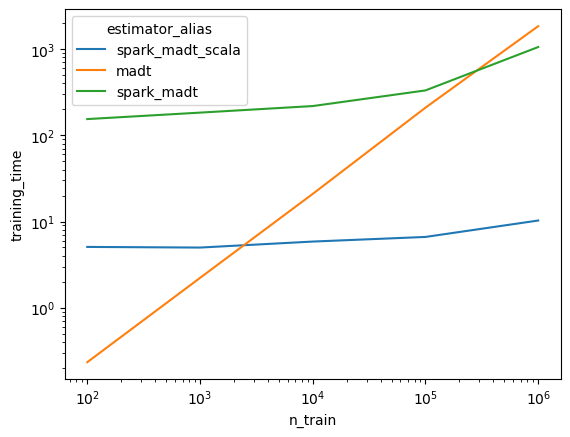

In [5]:
ax = sns.lineplot(
    data=results,
    x="n_train",
    y="training_time",
    hue="estimator_alias",
)
ax.set_xscale("log")
ax.set_yscale("log")

## Increasing the number of features

In the second experiment, we increase the number of features from 10 to 100,000, using a fixed sample size of 1,000. The training time is measured in seconds. We launch a local master using all available cores for the Spark-based implementations.

Clearly, the number of features is much more time-critical than the number of samples. For a small number of features, the pure Python-based implementation is the fastest, but as the number of features increases, the benefits of a distributed solution become evident. With 10,000 features, the Scala-based implementation is more than an order of magnitude faster than the pure Python-based implementation. The Python-based implementation utilizing RDD operations in PySpark is the least efficient. While the Scala-based implementation distributes the collection of node-splitting statistics across all workers, the PySpark-based implementation iterates over all features in a single for loop, similar to the pure Python implementation. Clearly, this solution does not scale well.

In [6]:
experiment_dir = "/proj/healthyai/matrees/results_02/"

In [7]:
results = collect_results(experiment_dir)

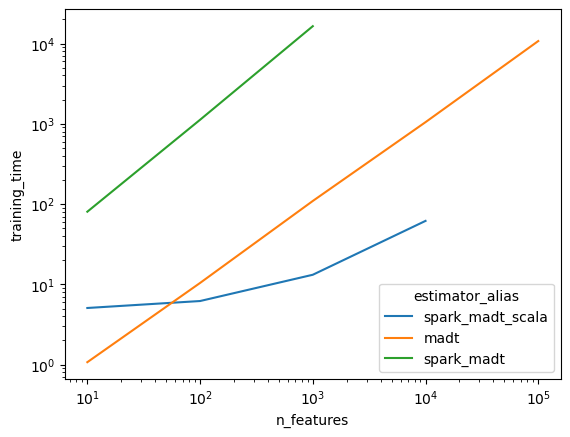

In [8]:
ax = sns.lineplot(
    data=results,
    x="n_features",
    y="training_time",
    hue="estimator_alias",
)
ax.set_xscale("log")
ax.set_yscale("log")

## Varying the strength of the missingness regularization

In the third experiment, we vary the strength of the missingness regularization, controlled by the value of a parameter $\alpha$. For each regularization strength, we measure accuracy and missingness reliance for each estimator. We repeat this experiment for five different seeds. We launch a local master using all available cores for the Spark-based implementations.

The accuracy and missingness reliance of all implementations align closely, indicating that the Spark source code has been correctly modified to handle MA trees. However, further testing is needed before the correctness of the implementation can be confirmed. In this toy example, it is possible to reduce the missingness reliance from 0.6 to 0.4 without compromising the classifier's performance.

In [9]:
experiment_dir = "/proj/healthyai/matrees/results_03/"

In [10]:
results = collect_results(experiment_dir)

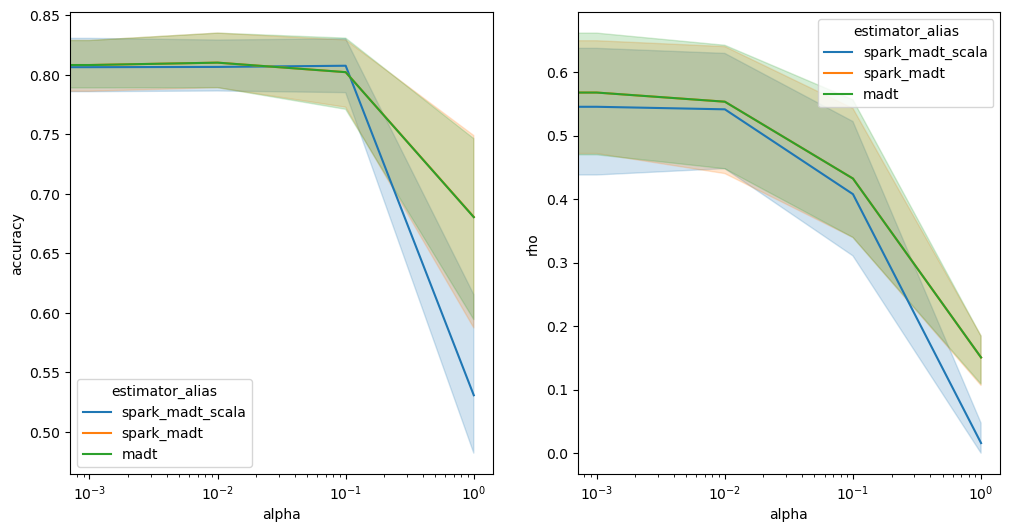

In [11]:
_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(
    data=results,
    x="alpha",
    y="accuracy",
    hue="estimator_alias",
    ax=ax1,
)

sns.lineplot(
    data=results,
    x="alpha",
    y="rho",
    hue="estimator_alias",
    ax=ax2,
)

ax1.set_xscale("log")
ax2.set_xscale("log")